In [7]:
%load_ext autoreload
%autoreload 2

from IPython.display import display

import pandas as pd
import numpy as np

from torchvision import transforms

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from models import *
from preprocessing import AdjustContrast, generate_dataloader, get_labels_mapping
from plotting import *

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
DATASET = "marmal88/skin_cancer"

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device : {device}")

Using device : cuda


## Import and preprocess data

In [10]:
le = LabelEncoder()

# Basic transformations for all images :
# Resize to 256x256 pixels and transform to tensor
preprocess_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor()
])

# Data augmentation techniques for minority classes
# see more in preprocessing.py
train_transform = transforms.Compose([
    transforms.RandomChoice([
        # Mirroring
        transforms.RandomHorizontalFlip(p=1),
        # Rotate randomly from 0 to 180 degrees
        transforms.RandomRotation(degrees=(0, 180)),
        # Reduces contrast by 10%
        AdjustContrast(contrast_factor=0.90),
        # Increases contrast by 10%
        AdjustContrast(contrast_factor=1.10)
    ])
])

# Center crop for validation and test set
val_test_transform = transforms.Compose([
    transforms.CenterCrop(size=(224, 224))
])

In [11]:
# Create training dataloader
train_dataloader = generate_dataloader(
    dataset=DATASET,
    part_set='train',
    preprocess_transform=preprocess_transform,
    label_encoder=le,
    minority_classes=[0, 3, 6],
    transform=train_transform,
    train=True,
    batch_size=64,
    shuffle=True
)

# Create validation dataloader
valid_dataloader = generate_dataloader(
    dataset=DATASET,
    part_set='validation',
    preprocess_transform=preprocess_transform,
    label_encoder=le,
    minority_classes=[0, 3, 6],
    transform=val_test_transform,
    train=False,
    batch_size=64,
    shuffle=True
)

# Create testing dataloader
test_dataloader = generate_dataloader(
    dataset=DATASET,
    part_set='test',
    preprocess_transform=preprocess_transform,
    label_encoder=le,
    minority_classes=[0, 3, 6],
    transform=val_test_transform,
    train=False,
    batch_size=64,
    shuffle=True
)

### Cancer repartition

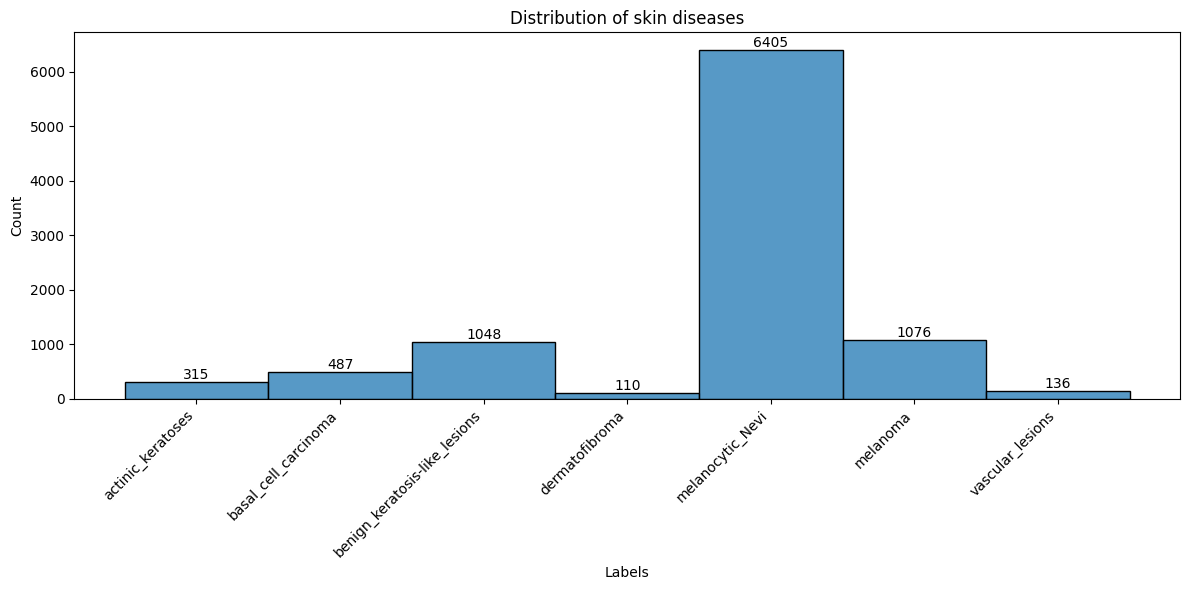

In [12]:
label_mapping = get_labels_mapping(le)
plot_diseases_repartition(train_dataloader, label_mapping)

Randomly select an image and display it with its associated disease.

basal_cell_carcinoma


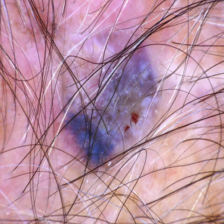

In [27]:
idx = np.random.choice(len(train_dataloader.dataset))
img = transforms.ToPILImage()(train_dataloader.dataset[idx]['image'])
label = label_mapping[train_dataloader.dataset[idx]['label'].item()]
print(label)
display(img)

# Train and evaluate model

In [30]:
model = ResNet18(num_classes=7).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=5, gamma=0.9)
early_stopping = EarlyStopping(patience=5, delta=0)

n_epochs = 50

train_loss_history, train_accuracy_history = [], []
val_loss_history, val_accuracy_history = [], []

for epoch in range(1, n_epochs + 1):
    # Train the model
    epoch_train_loss, epoch_train_accuracy = train_model(
        model=model,
        device=device,
        train_loader=train_dataloader,
        loss_function=criterion,
        optimizer=optimizer,
        epoch=epoch,
        save=True,
        verbose=2
    )
    # Save training metrics_2_2
    train_loss_history.append(epoch_train_loss)
    train_accuracy_history.append(epoch_train_accuracy)

    # Validation part
    epoch_val_loss, epoch_val_accuracy = validate_model(
        model=model,
        device=device,
        valid_loader=valid_dataloader,
        loss_function=criterion,
        save=True,
        verbose=True
    )
    # Save validation metrics
    val_loss_history.append(epoch_val_loss)
    val_accuracy_history.append(epoch_val_accuracy)

    # Check for early stopping
    early_stopping(epoch_val_loss, model, epoch)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    scheduler.step()

# If early stopping, load best model parameters in current model
early_stopping.load_best_model(model)

Train Epoch 1 [0/9577 (0%)]	Loss: 2.156132
Train Epoch 1 [640/9577 (7%)]	Loss: 0.951339
Train Epoch 1 [1280/9577 (13%)]	Loss: 0.826366
Train Epoch 1 [1920/9577 (20%)]	Loss: 0.655925
Train Epoch 1 [2560/9577 (27%)]	Loss: 0.787559
Train Epoch 1 [3200/9577 (33%)]	Loss: 0.924277
Train Epoch 1 [3840/9577 (40%)]	Loss: 0.665980
Train Epoch 1 [4480/9577 (47%)]	Loss: 0.766429
Train Epoch 1 [5120/9577 (53%)]	Loss: 0.892189
Train Epoch 1 [5760/9577 (60%)]	Loss: 0.911212
Train Epoch 1 [6400/9577 (67%)]	Loss: 0.780727
Train Epoch 1 [7040/9577 (74%)]	Loss: 0.985202
Train Epoch 1 [7680/9577 (80%)]	Loss: 0.918446
Train Epoch 1 [8320/9577 (87%)]	Loss: 0.688756
Train Epoch 1 [8960/9577 (94%)]	Loss: 0.939923

Train set : Average loss 0.8443, Accuracy : 6620/9577 (69%)

Validation set : Average Loss: 0.8094, Accuracy : 1728/2492 (69%)

Train Epoch 2 [0/9577 (0%)]	Loss: 0.698289
Train Epoch 2 [640/9577 (7%)]	Loss: 0.968742
Train Epoch 2 [1280/9577 (13%)]	Loss: 0.587387
Train Epoch 2 [1920/9577 (20%)]	Loss:

In [31]:
# Empty device cache
torch.cuda.empty_cache()

## Loss and accuracy plots

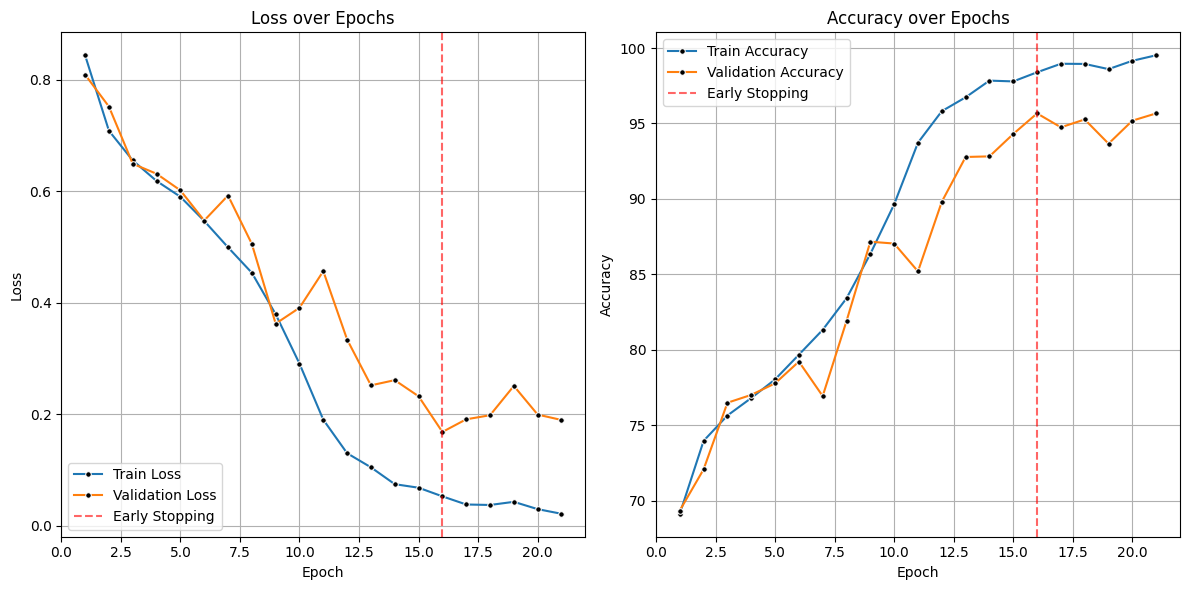

In [53]:
plot_loss_and_accuracy(train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history, early_stopping, n_epochs)

# Model performance on test set

In [56]:
metrics = test_model(
    models=model,
    device=device,
    test_loader=test_dataloader,
    verbose=True
)

Test accuracy : 1214/1285 (94.47%)


## Precision, Recall and F1-Score

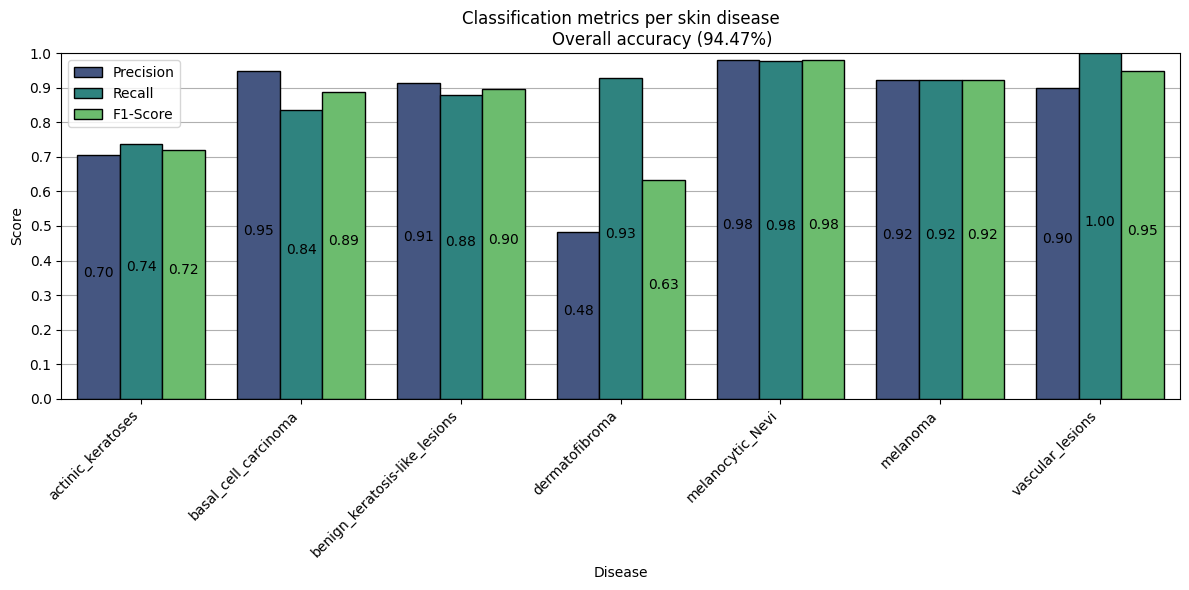

In [57]:
plot_per_class_metrics(metrics, label_mapping)

## Confusion Matrix

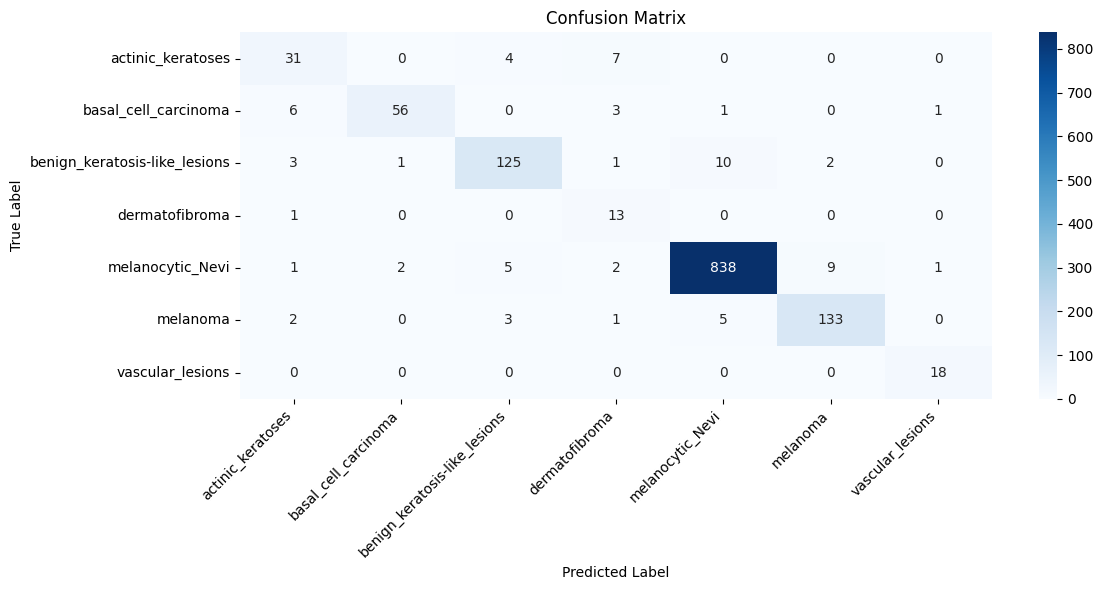

In [59]:
plot_confusion_matrix(
    y_true=metrics['correct_labels'],
    y_pred=metrics['predicted_labels'],
    class_names=label_mapping.values(),
    normalize=False
)

Predict on a randomly chosen image from the test set and plots the predictions with associated probabilities

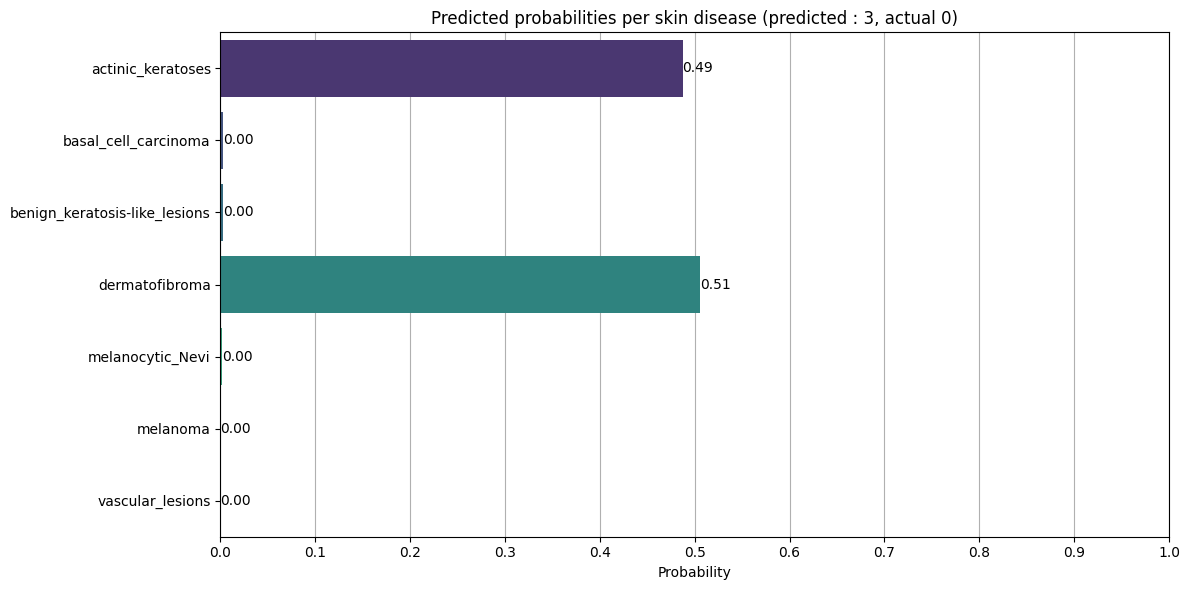

In [65]:
# Pick an example from the dataset
idx = np.random.choice(len(test_dataloader.dataset))
example = test_dataloader.dataset[idx]['image'].unsqueeze(0).to(device)
example_label = test_dataloader.dataset[idx]['label'].unsqueeze(0).to(device)

with torch.no_grad():
    output = model(example)
    predicted = output.argmax(1).item()
    actual = example_label.item()

probs = nn.functional.softmax(output[0], dim=0).tolist()

df = pd.DataFrame({
    'Class': list(label_mapping.values()),
    'Probability': probs
})

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=df, y='Class', x='Probability', hue='Class', ax=ax, palette='viridis')
ax.set_axisbelow(True)

# Add text labels
for i in range(len(df)):
    ax.text(df['Probability'][i], i, f"{df['Probability'][i]:.2f}", va='center')

ax.set_title(f"Predicted probabilities per skin disease (predicted : {predicted}, actual {actual})")
ax.set_xlabel("Probability")
ax.set_ylabel("")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 1)
plt.grid(visible=True, axis='x')
plt.tight_layout()
plt.show()


# Combining two ResNet-18

In [66]:
model_2 = ResNet18().to(device)
model_2.load_state_dict(torch.load("Models/ResNet18_mirroring_contrast10.pth", weights_only=True))
model_2.eval()

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [67]:
metrics_2 = test_model(
    models=model_2,
    device=device,
    test_loader=test_dataloader,
    verbose=True
)

Test accuracy : 1191/1285 (92.68%)


In [68]:
metrics_combine = test_model(
    models = [model, model_2],
    device=device,
    test_loader=test_dataloader,
    verbose=True
)

Test accuracy : 1230/1285 (95.72%)


## Precision, Recall and F1-Score

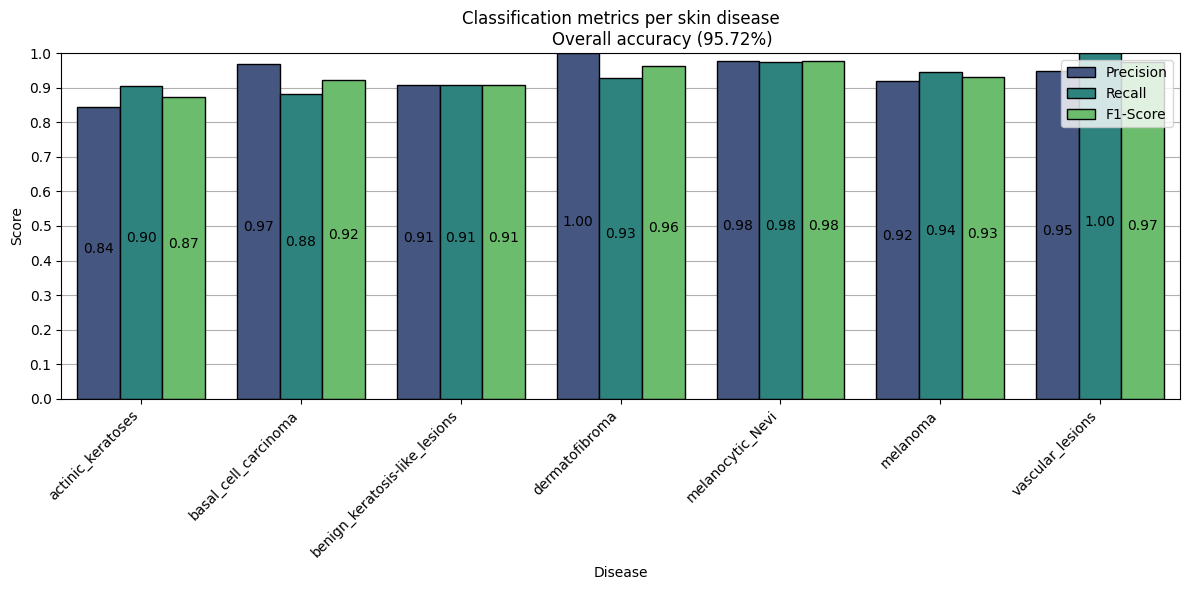

In [69]:
plot_per_class_metrics(
    metrics=metrics_combine,
    label_mapping=label_mapping
)

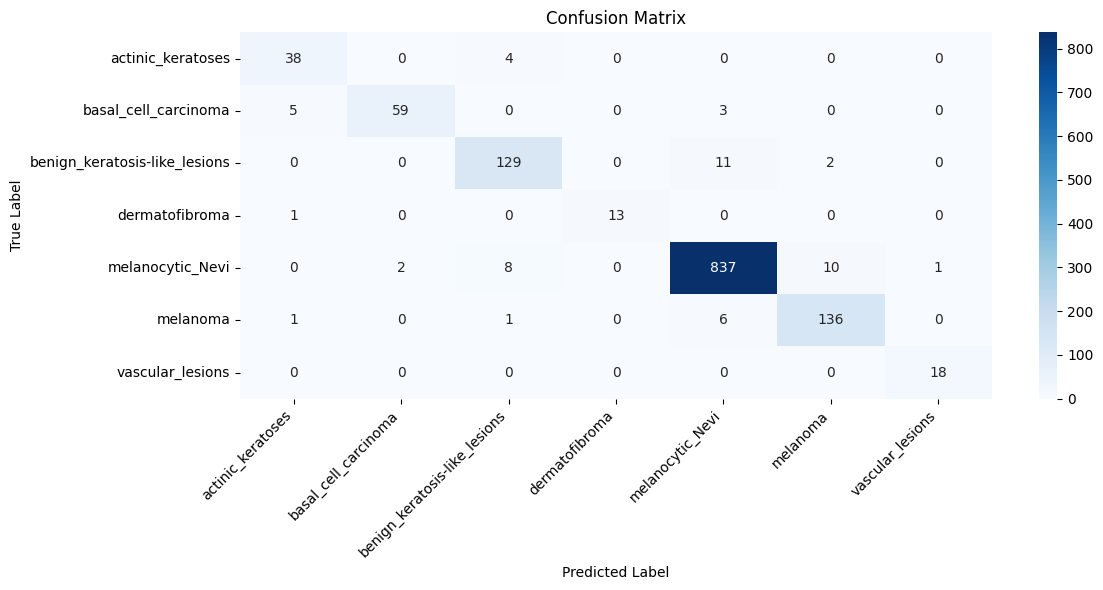

In [70]:
plot_confusion_matrix(
    y_true=metrics_combine['correct_labels'],
    y_pred=metrics_combine['predicted_labels'],
    class_names=label_mapping.values(),
    normalize=False
)

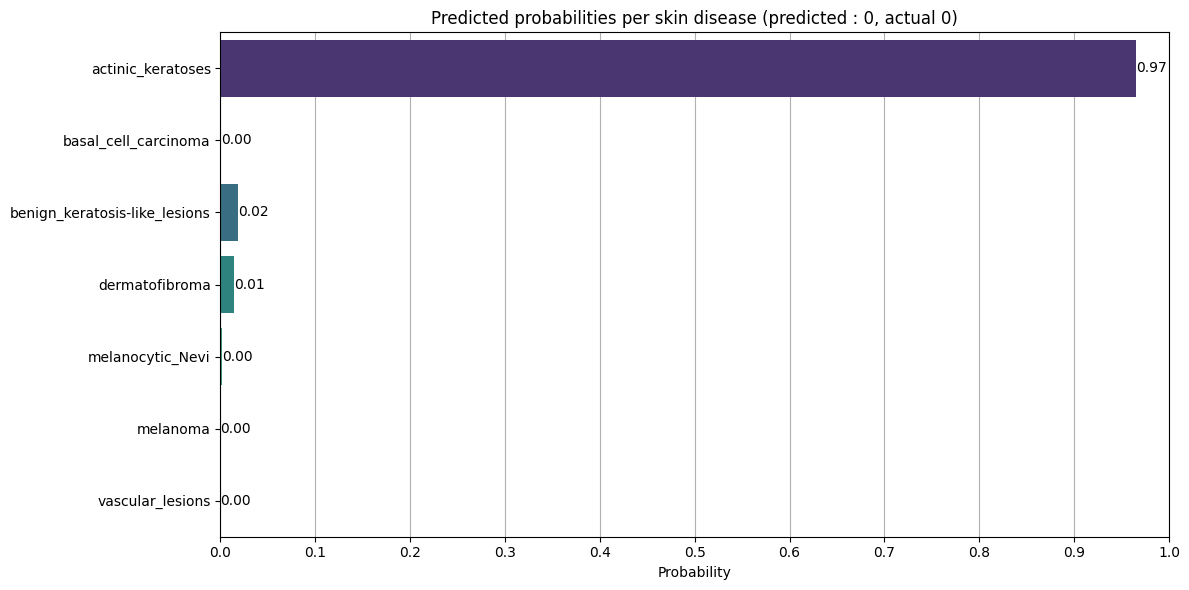

In [71]:
with torch.no_grad():
    output = get_models_predictions(models=[model, model_2], input_tensor=example)
    predicted = output.argmax(1).item()
    actual = example_label.item()

probs = nn.functional.softmax(output[0], dim=0).tolist()

df = pd.DataFrame({
    'Class': list(label_mapping.values()),
    'Probability': probs
})

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=df, y='Class', x='Probability', hue='Class', ax=ax, palette='viridis')
ax.set_axisbelow(True)

# Add text labels
for i in range(len(df)):
    ax.text(df['Probability'][i], i, f"{df['Probability'][i]:.2f}", va='center')

ax.set_title(f"Predicted probabilities per skin disease (predicted : {predicted}, actual {actual})")
ax.set_xlabel("Probability")
ax.set_ylabel("")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 1)
plt.grid(visible=True, axis='x')
plt.tight_layout()
plt.show()

# Combining three ResNet-18

In [72]:
model_3 = ResNet18().to(device)
model_3.load_state_dict(torch.load("Models/ResNet18_mirroring_contrast10_2.pth", weights_only=True))
model_3.eval()

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [75]:
metrics_3 = test_model(
    models=model_3,
    device=device,
    test_loader=test_dataloader,
    verbose=True
)

c:\Users\flori\anaconda3\envs\cv_skin_cancer\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test accuracy : 1198/1285 (93.23%)


In [76]:
metrics_three_combine = test_model(
    models = [model, model_2, model_3],
    device=device,
    test_loader=test_dataloader,
    verbose=True
)

Test accuracy : 1243/1285 (96.73%)


## Precision, Recall and F1-Score

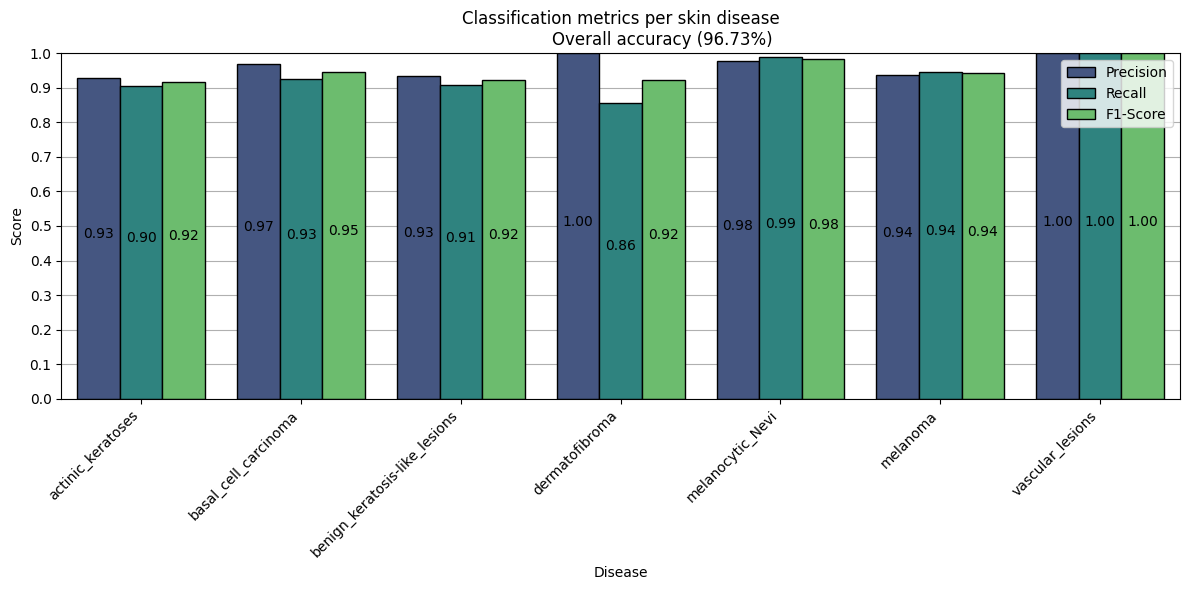

In [77]:
plot_per_class_metrics(
    metrics=metrics_three_combine,
    label_mapping=label_mapping
)

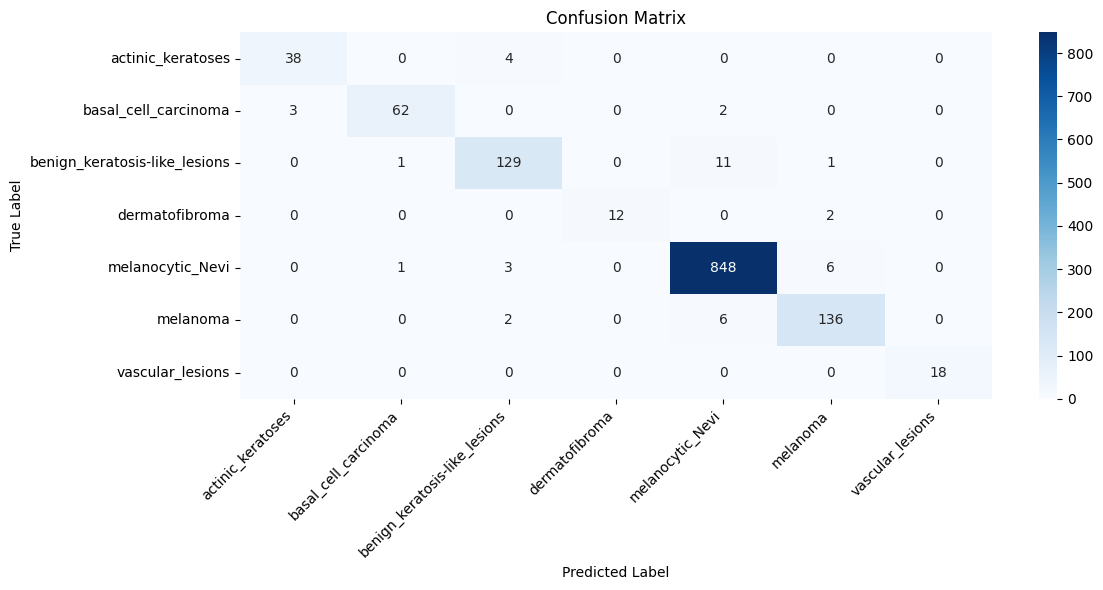

In [78]:
plot_confusion_matrix(
    y_true=metrics_three_combine['correct_labels'],
    y_pred=metrics_three_combine['predicted_labels'],
    class_names=label_mapping.values(),
    normalize=False
)

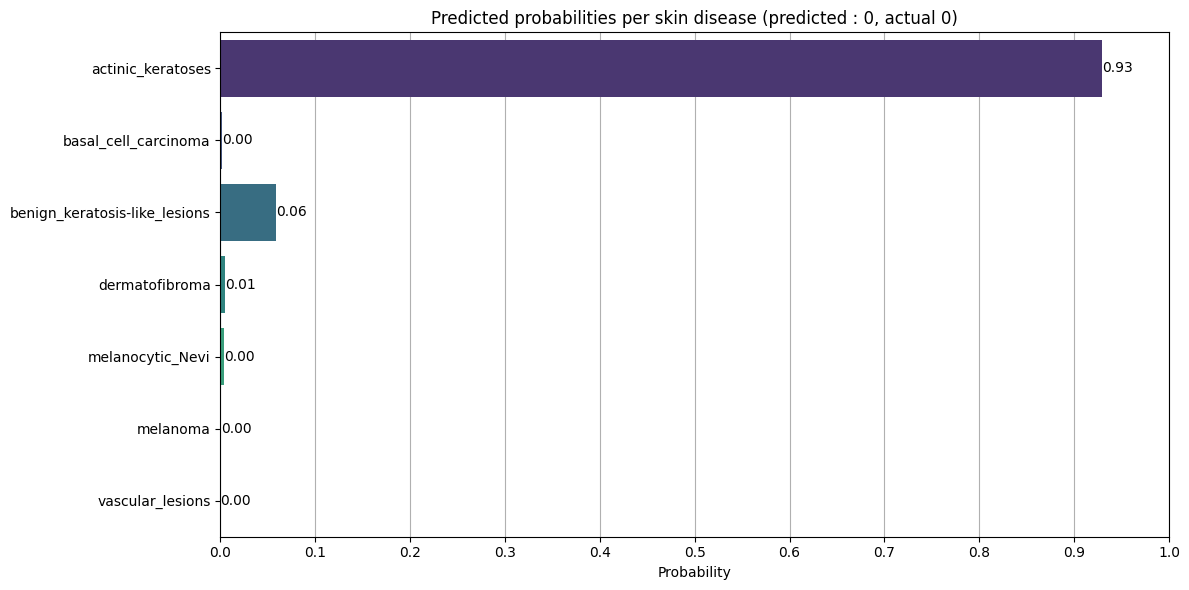

In [79]:
with torch.no_grad():
    output = get_models_predictions(models=[model, model_2, model_3], input_tensor=example)
    predicted = output.argmax(1).item()
    actual = example_label.item()
  
probs = nn.functional.softmax(output[0], dim=0).tolist()

df = pd.DataFrame({
    'Class': list(label_mapping.values()),
    'Probability': probs
})

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=df, y='Class', x='Probability', hue='Class', ax=ax, palette='viridis')
ax.set_axisbelow(True)

# Add text labels
for i in range(len(df)):
    ax.text(df['Probability'][i], i, f"{df['Probability'][i]:.2f}", va='center')

ax.set_title(f"Predicted probabilities per skin disease (predicted : {predicted}, actual {actual})")
ax.set_xlabel("Probability")
ax.set_ylabel("")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 1)
plt.grid(visible=True, axis='x')
plt.tight_layout()
plt.show()